In [1]:
import pandas
import hazm
import re
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

## Load dataset

In [2]:
data=pandas.read_csv("taghche.csv")

In [3]:
data.head()

,date,comment,bookname,rate,bookID,like
0,1395/11/14,اسم کتاب No one writes to the Colonel\nترجمش...,سرهنگ کسی ندارد برایش نامه بنویسد,0.0,3.0,2.0
1,1395/11/14,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",سرهنگ کسی ندارد برایش نامه بنویسد,5.0,3.0,2.0
2,1394/06/06,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,سرهنگ کسی ندارد برایش نامه بنویسد,5.0,3.0,0.0
3,1393/09/02,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,سرهنگ کسی ندارد برایش نامه بنویسد,2.0,3.0,0.0
4,1393/06/29,کتاب خوبی است,سرهنگ کسی ندارد برایش نامه بنویسد,3.0,3.0,0.0


In [4]:
# If the rate is more than 3, then the label is positive.

temp=[]
for i in range(len(data)):
    text=data.loc[i,"comment"]
    rate=data.loc[i,"rate"]
    
    if not pandas.isna(text) and not pandas.isna(rate):
        if rate>3:
            label=1 # positive
        else:
            label=0 # negative
            
        temp.append([text,label])
              

dataset= pandas.DataFrame(temp,columns=["comment","label"])

In [5]:
dataset.head()

,comment,label
0,اسم کتاب No one writes to the Colonel\nترجمش...,0
1,"طاقچه عزیز،نام کتاب""کسی به سرهنگ نامه نمینویسد...",1
2,بنظرم این اثر مارکز خیلی از صد سال تنهایی که ب...,1
3,به نظر کتاب خوبی میومد اما من از ترجمش خوشم نی...,0
4,کتاب خوبی است,0


## Pre-Processing

1. Emoji removing
2. Normalizing
3. Half-Space correction
4. English character removing


In [6]:
normalizer=hazm.Normalizer()

In [7]:
def EmojiRemoving(text):

    emoj = re.compile("["
                      u"\U0001F600-\U0001F64F"  # emoticons
                      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                      u"\U0001F680-\U0001F6FF"  # transport & map symbols
                      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                      u"\U00002500-\U00002BEF"  # chinese char
                      u"\U00002702-\U000027B0"
                      u"\U00002702-\U000027B0"
                      u"\U000024C2-\U0001F251"
                      u"\U0001f926-\U0001f937"
                      u"\U00010000-\U0010ffff"
                      u"\u2640-\u2642"
                      u"\u2600-\u2B55"
                      u"\u200d"
                      u"\u23cf"
                      u"\u23e9"
                      u"\u231a"
                      u"\ufe0f"  # dingbats
                      u"\u3030"
                      "]+", re.UNICODE)
    text= re.sub(emoj, '', text)

    return text


def hSpace_correction(text):
    
    text = text.replace("\u200c", " ")
    
    return text

def english_removing(text):
    
    maintext = re.sub(r'[a-zA-Z]', '', text)
    
    return maintext


In [8]:
#example 
# Before pre-processing
print(dataset.loc[57196,"comment"])

راستش شاید نظر من از نظر خوانندگان عادلانه نباشه 🤭 ولی چون من کتاب های زیادی در این زمینه خوندم، این کتاب برام تازگی نداشت. به نظرم این مدل کتاب ها حالت مسکن داره بر روی روان ما. هیچ چیز مثل تجربه ها نمیتونه به ما یاد بده قدر خودمون رو بدونیم.
در کل برای من چیز wow و تازه ای نبود. 🤭


In [9]:
dataset["comment"]=dataset["comment"].apply(EmojiRemoving) 

In [10]:
#example
print(dataset.loc[57196,"comment"])

راستش شاید نظر من از نظر خوانندگان عادلانه نباشه  ولی چون من کتاب های زیادی در این زمینه خوندم، این کتاب برام تازگی نداشت. به نظرم این مدل کتاب ها حالت مسکن داره بر روی روان ما. هیچ چیز مثل تجربه ها نمیتونه به ما یاد بده قدر خودمون رو بدونیم.
در کل برای من چیز wow و تازه ای نبود. 


In [11]:
dataset["comment"]=dataset["comment"].apply(normalizer.normalize)

In [12]:
#example
print(dataset.loc[57196,"comment"])

راستش شاید نظر من از نظر خوانندگان عادلانه نباشه ولی چون من کتاب‌های زیادی در این زمینه خوندم، این کتاب برام تازگی نداشت. به نظرم این مدل کتاب‌ها حالت مسکن داره بر روی روان ما. هیچ چیز مثل تجربه‌ها نمیتونه به ما یاد بده قدر خودمون رو بدونیم. 
در کل برای من چیز wow و تازه‌ای نبود. 


In [13]:
dataset["comment"]=dataset["comment"].apply(hSpace_correction)

In [14]:
#example
print(dataset.loc[57196,"comment"])

راستش شاید نظر من از نظر خوانندگان عادلانه نباشه ولی چون من کتاب های زیادی در این زمینه خوندم، این کتاب برام تازگی نداشت. به نظرم این مدل کتاب ها حالت مسکن داره بر روی روان ما. هیچ چیز مثل تجربه ها نمیتونه به ما یاد بده قدر خودمون رو بدونیم. 
در کل برای من چیز wow و تازه ای نبود. 


In [15]:
dataset["comment"]=dataset["comment"].apply(english_removing)

In [16]:
#example
print(dataset.loc[57196,"comment"])

راستش شاید نظر من از نظر خوانندگان عادلانه نباشه ولی چون من کتاب های زیادی در این زمینه خوندم، این کتاب برام تازگی نداشت. به نظرم این مدل کتاب ها حالت مسکن داره بر روی روان ما. هیچ چیز مثل تجربه ها نمیتونه به ما یاد بده قدر خودمون رو بدونیم. 
در کل برای من چیز  و تازه ای نبود. 


## Vectorizing

In [19]:
X=list(dataset["comment"])
Y=list(dataset["label"])

In [24]:
# Split train and test subset.

train, test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [21]:
with open('stopwords.txt') as f:
       sw = [re.sub(r"[\u200c-\u200f]"," ",line.rstrip()) for line in f]

In [22]:
# Example of stop words

sw[50:60]

['آنچنان',
 'آنچنان که',
 'اونجور',
 'اونجوری',
 'اونجوری که',
 'آنچه',
 'آنکه',
 'آنگاه',
 'آن ها',
 'آهان']

In [26]:
vectorizer = TfidfVectorizer(stop_words=sw)

In [27]:
X_train = vectorizer.fit_transform(train)

/home/rahnama/mohadese/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آسانی', 'آسیب', 'آینده', 'اثر', 'احیانا', 'اخیرا', 'ازاین', 'اسلامی', 'اطلاعند', 'الاسف', 'البت', 'الظاهر', 'بااین', 'بازی', 'باوجودی', 'برآن', 'برنامه', 'بسته', 'بطوری', 'بفهمی', 'تازگی', 'تحریم', 'تدریج', 'ترتیب', 'تردید', 'ترند', 'تصریحا', 'تفاوتند', 'تند', 'توؤما', 'تول', 'تک', 'تی', 'ثالثا', 'ثانی', 'جمع', 'جمله', 'جنس', 'جوری', 'حاشیه', 'حسابی', 'حکما', 'خارج', 'خدا', 'خسته', 'خوانم', 'خوانید', 'خوبی', 'خودبه', 'خودی', 'داند', 'دراین', 'درحالی', 'درشتی', 'درصورتی', 'درعین', 'درپی', 'دسته', 'دلخواه', 'دنبال', 'دیوانه', 'ذاتا', 'ذلک', 'راجع', 'رسد', 'رضای', 'رغم', 'رود', 'روزه', 'روشنی', 'زده', 'زودی', 'ساده', 'سادگی', 'سازهاست', 'سالم', 'ساله', 'ست', 'سرعت', 'سمت', 'سه', 'سهوا', 'سیاه', 'شاأالله', 'شدت', 'صریحا', 'صندوق', 'ضد', 'ضمنا', 'طبق', 'طوری', 'عل', 'علاقه', 'علاوه', 

In [28]:
X_test = vectorizer.transform(test)

## Classification

In [31]:
clf_SVC_basic = svm.SVC(kernel="rbf")
clf_SVC_OneVsRest = OneVsRestClassifier(estimator=clf_SVC_basic)

In [32]:
clf_SVC = clf_SVC_OneVsRest.fit(X_train,y_train)

## Evaluation

In [33]:
y_pred_SVC = clf_SVC.predict(X_test)

In [46]:
print(classification_report(y_test, y_pred_SVC,target_names=["Negative","Positive"]))

              precision    recall  f1-score   support

    Negative       0.74      0.39      0.51      4238
    Positive       0.78      0.94      0.85      9720

    accuracy                           0.77     13958
   macro avg       0.76      0.66      0.68     13958
weighted avg       0.77      0.77      0.75     13958



/home/rahnama/mohadese/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


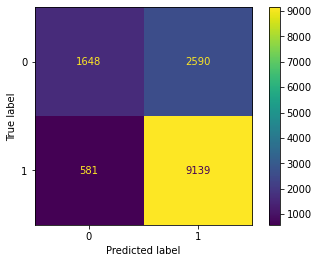

In [41]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(clf_SVC,X_test,y_test)
plt.show()